In [1]:
import pandas as pd
import copy
import requests
from tqdm.notebook import tqdm
from tqdm import tqdm
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By          # - 정보 획득
from selenium.webdriver.common.keys import Keys
# from engine_connect import create_engine_connect, db_connection
from sqlalchemy import create_engine
import os
import re
import time
from bs4 import BeautifulSoup
import warnings
import pymysql
import math
warnings.filterwarnings(action='ignore')
from selenium.webdriver.common.action_chains import ActionChains
import json


import time
import datetime as dt # 사용시 datetime.dt 로 사용 # 현재 시간 사용
from datetime import datetime # 사용시 함수로 바로 사용 #-> 시간 비교

In [4]:
import matplotlib.font_manager as fm
fm._rebuild()

AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용
plt.rcParams.update({'font.family': 'NanumBarunGothic'})

import scipy
import scipy.stats as stats
# 경고창 무시
import warnings
warnings.filterwarnings('ignore')

AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

In [3]:
directory = os.getcwd()
print("Current working directory : ", directory)

#수집날짜
folder_date = str(dt.datetime.now().date())
folder_date = re.sub("-", ".", folder_date)
today = re.sub("\.", "", folder_date)
print('오늘 날짜 : ', folder_date)

now = dt.datetime.now()
print('현재 시간 : ', now)

Current working directory :  C:\Develops\Your_Lung_may_be_Wrong
오늘 날짜 :  2024.08.04
현재 시간 :  2024-08-04 17:55:04.538797


In [4]:
df_cancer_statistics = pd.read_excel(f"{directory}/data/cancer_incidence_and_mortality_statistics.xlsx")
df_cancer_statistics

,연도,암 종류,사망자수,조사망률
0,1983,모든 암(C00-C97),28787,72.1
1,1983,위암(C16),12145,30.4
2,1983,대장암(C18-C21),666,1.7
3,1983,간암(C22),6384,16.0
4,1983,폐암(C33-C34),2360,5.9
...,...,...,...,...
315,2022,간암(C22),10212,19.9
316,2022,폐암(C33-C34),18584,36.3
317,2022,유방암(C50),2878,5.6
318,2022,자궁암(C53-C55),1304,2.5


### 데이터 확인

In [5]:
df_cancer_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연도      320 non-null    int64  
 1   암 종류    320 non-null    object 
 2   사망자수    320 non-null    int64  
 3   조사망률    320 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 10.1+ KB


In [6]:
df_cancer_statistics["암 종류"].unique()

array(['모든\xa0암(C00-C97)', '위암(C16)', '대장암(C18-C21)', '간암(C22)',
       '폐암(C33-C34)', '유방암(C50)', '자궁암(C53-C55)', '기타암(Re.C00-C97)'],
      dtype=object)

In [7]:
df_cancer_statistics[["사망자수","조사망률"]].describe()

,사망자수,조사망률
count,320.000000,320.000000
mean,14782.468750,30.790625
std,19051.462819,38.702750
min,414.000000,1.000000
25%,2186.750000,4.350000
50%,9378.000000,20.050000
75%,14919.000000,31.400000
max,83378.000000,162.700000


### 데이터 전처리

In [8]:
df_cancer_statistics.isnull().sum()

연도      0
암 종류    0
사망자수    0
조사망률    0
dtype: int64

In [9]:
df_cancer_statistics.duplicated().sum()

0

In [10]:
# 정규표현식 패턴
pattern = r'^(.*?)\('

# 숫자들을 저장할 리스트
list_cancer_type = []

for x in range(len(df_cancer_statistics)):
    match = re.search(pattern, df_cancer_statistics["암 종류"].iloc[x])
    if match:
        list_cancer_type.append(match.group(1))
df_cancer_statistics["암 종류"] = list_cancer_type
df_cancer_statistics

,연도,암 종류,사망자수,조사망률
0,1983,모든 암,28787,72.1
1,1983,위암,12145,30.4
2,1983,대장암,666,1.7
3,1983,간암,6384,16.0
4,1983,폐암,2360,5.9
...,...,...,...,...
315,2022,간암,10212,19.9
316,2022,폐암,18584,36.3
317,2022,유방암,2878,5.6
318,2022,자궁암,1304,2.5


In [11]:
df_cancer_statistics["암 종류"].value_counts()

암 종류
모든 암    40
위암      40
대장암     40
간암      40
폐암      40
유방암     40
자궁암     40
기타암     40
Name: count, dtype: int64

### DDA

In [12]:
df_cancer_statistics

,연도,암 종류,사망자수,조사망률
0,1983,모든 암,28787,72.1
1,1983,위암,12145,30.4
2,1983,대장암,666,1.7
3,1983,간암,6384,16.0
4,1983,폐암,2360,5.9
...,...,...,...,...
315,2022,간암,10212,19.9
316,2022,폐암,18584,36.3
317,2022,유방암,2878,5.6
318,2022,자궁암,1304,2.5


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

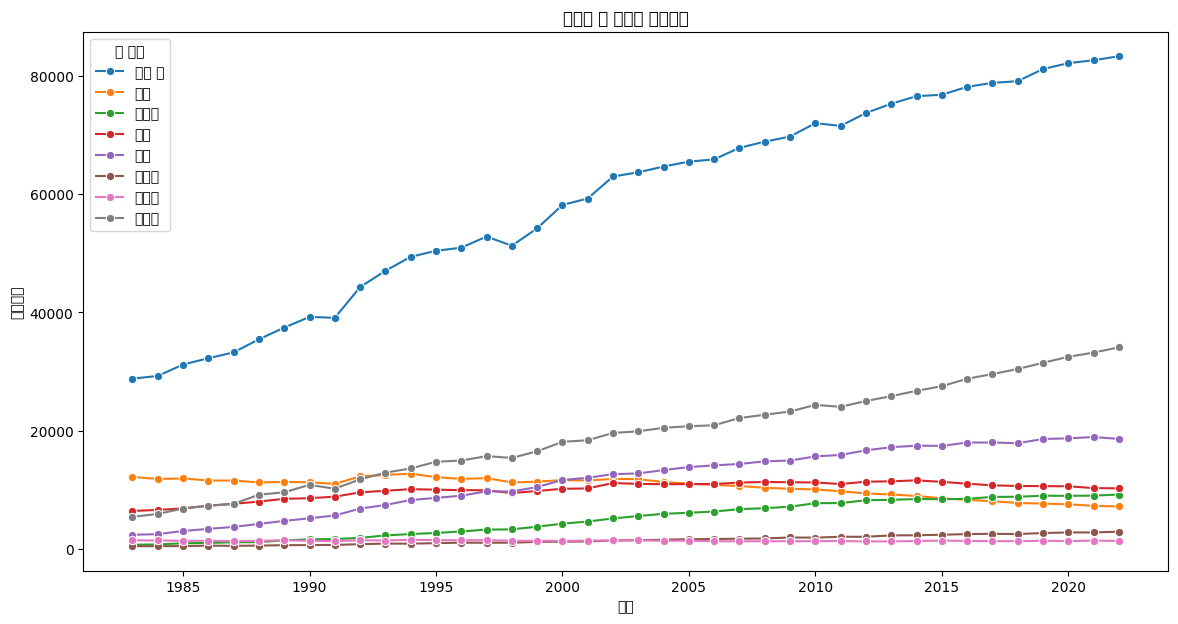

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

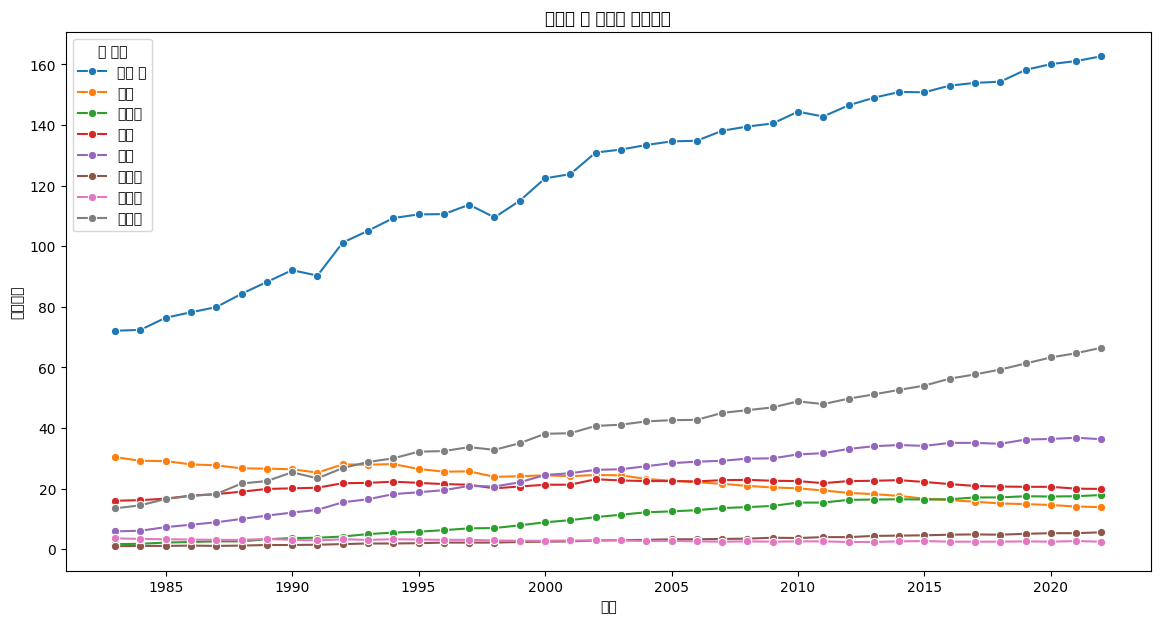

In [15]:
# 사망자수 그래프
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_cancer_statistics, x="연도", y="사망자수", hue="암 종류", marker="o")
plt.title("연도별 암 종류별 사망자수")
plt.xlabel("연도")
plt.ylabel("사망자수")
plt.legend(title="암 종류")
plt.show()

# 조사망률 그래프
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_cancer_statistics, x="연도", y="조사망률", hue="암 종류", marker="o")
plt.title("연도별 암 종류별 조사망률")
plt.xlabel("연도")
plt.ylabel("조사망률")
plt.legend(title="암 종류")
plt.show()